# Introduction 
<p>The following code is written to evaluate a two-layer neural network model in dealing with the MNIST Dataset. Applying the basics of Gradient Desecent, it yields a convicing ~80% accuracy on the test set (data which it has never seen before). Of course, the model has not been further optimized and this is just a good start. Enjoy! :) <p>

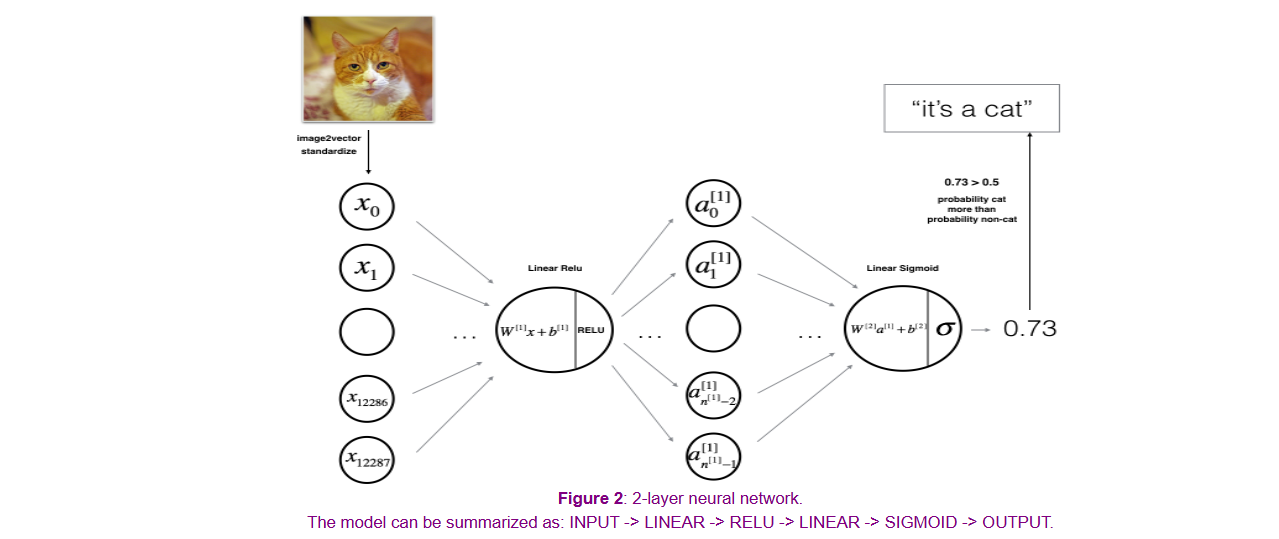

# Cleansing Data


In [2]:
import numpy as np
import struct
from array import array
from matplotlib import pyplot as plt
import os

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [3]:
#Reading Data
base_dir = "input"
training_images_filepath = os.path.join(base_dir, "train-images-idx3-ubyte/train-images-idx3-ubyte")
training_labels_filepath = os.path.join(base_dir, "train-labels-idx1-ubyte/train-labels-idx1-ubyte")
test_images_filepath = os.path.join(base_dir, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels_filepath = os.path.join(base_dir, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [4]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

train_x_flatten = x_train.reshape(x_train.shape[0], -1).T # (784, 60000)
test_x_flatten = x_test.reshape(x_test.shape[0], -1).T # (784, 10000)

train_x = train_x_flatten
test_x = test_x_flatten

# Initializing Parameters and Helper Functions

In [5]:
def intialize_parameters():
    W1 = np.random.rand(64, 784) - 0.5 # 64 neurons, 784 features
    b1 = np.random.rand(64, 1) - 0.5
    W2 = np.random.rand(10, 64) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    assert(W1.shape == (64, 784))
    assert(b1.shape == (64, 1))
    assert(W2.shape == (10, 64))
    assert(b2.shape == (10, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# Forward Propagation & Backward Propagation

In [6]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def predict_test_set(X_test, y_test, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X_test)
    predictions = get_predictions(A2)
    accuracy = get_accuracy(predictions, y_test)
    print(f"Test set accuracy: {accuracy * 100:.2f}%")
    return predictions

# Model 

In [7]:
def model(X, Y, alpha, iterations):
    W1, b1, W2, b2 = intialize_parameters()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [ ]:
#Trainging the Model
W1, b1, W2, b2 = model(train_x, y_train, 0.2, 150) # 150 iterations, 0.2 alpha


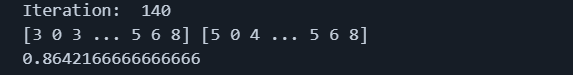

In [ ]:
#Predicting the Test Set
predict_test_set(test_x, y_test, W1, b1, W2, b2)

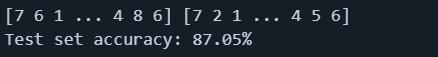